In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from numpy import genfromtxt

from scipy.interpolate import interp1d

from scipy.signal import argrelextrema

## Collect data from the Severson dataset as descrribed in https://data.matr.io/1/projects/5c48dd2bc625d700019f3204

batch1 = pickle.load(open(r'./STFD_DATA/batch1.pkl', 'rb'))

#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'./STFD_DATA/batch2.pkl','rb'))

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'./batch3.pkl', 'rb'))
#batch3 = pickle.load(open(r'./../../../../../../Documents/Stanford/Data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

numBat3 = len(batch3.keys())

43

In [5]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [6]:
bat_dict = {**batch1, **batch2, **batch3}

##each cycle contains the following data:
print(bat_dict[bk]['cycles']['20'].keys())

#here we print the charge policy
for i in bat_dict.keys():
    print(bat_dict[i]['charge_policy'])
    print(bat_dict[i]['summary']['cycle'].max())
    
# store in num_cycles.csv file the values of EOL per each battery of the database
num_cycles = []
for i in bat_dict.keys():
    num_cycles = np.append(num_cycles, bat_dict[i]['summary']['cycle'].max())
    
num_cycles = num_cycles.astype(int)
num_cycles = num_cycles -1

np.savetxt('./num_cycles.csv', num_cycles)

batt_names = list(bat_dict)

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

In [9]:
#Example of Voltage profile evolution for the battery 'b1c0'

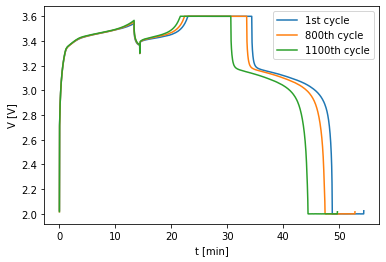

In [11]:
times = bat_dict['b1c0']['cycles']['1']['t']
voltages = bat_dict['b1c0']['cycles']['1']['V']
times_800 = bat_dict['b1c0']['cycles']['800']['t']
voltages_800 = bat_dict['b1c0']['cycles']['800']['V']
times_1100 = bat_dict['b1c0']['cycles']['1100']['t']
voltages_1100 = bat_dict['b1c0']['cycles']['1100']['V']

plt.plot(times, voltages, label = '1st cycle')
plt.plot(times_800, voltages_800, label = '800th cycle')
plt.plot(times_1100, voltages_1100, label = '1100th cycle')

plt.xlabel('t [min]')
plt.ylabel('V [V]')
plt.legend()
plt.savefig('./checkpoints/shift_V.png')

In [ ]:
## Here we define the functions used for automatic feature extraction

In [12]:
def return_tmax(batt):
    t_max = []
    max_cycle_n = num_cycles[batt]
    for c in range(1, max_cycle_n+1):
        t_max_cycle = bat_dict[batt_names[batt]]['cycles']['{}'.format(c)]['t'].max()
        t_max = np.append(t_max, t_max_cycle)  
    return t_max


norm_f = lambda x: (x-x.min())/(x.max()-x.min())

def inverseF(times, voltages):
    F_x = []
    F_y = []
    for i in range(0, len(times)): 
        F_x = np.append(F_x, voltages[i])    #return t(V)
        F_y = np.append(F_y, times[i])
    return F_x, F_y
    
def find_peaks(voltages):

    peaks = argrelextrema(voltages, np.greater, order = 30)
    #split_intervals = np.split(voltages, peaks[0])
    return peaks  

def find_pos_from_equi_to_exp(equisp_pos, x_range, x_equi):
    exp_pos = np.where((np.abs(x_range-x_equi[equisp_pos])).min()==(np.abs(x_range-x_equi[equisp_pos])))[0][0]
    return exp_pos

# Here we split the voltage charge/discharge profile into intervals 
# Each interval is identified with the change in sign of the curve's derivative
# However two reasons can cause the change of the derivative's sign:
# 1.) a new stage of the charge/discharge process (determined by a new charge/discharge step)
# 2.) experimental noise (in this case we assume the sign will change again after a few data points)
# case 2.) will be classified as a small discontinuity and will not contribute in the identification of a new interval 

list_p = lambda x: x[np.arange(0, len(x)-1, 1)] # return positions in an array until penultimate value
list_next_p = lambda x: x[np.arange(1, len(x), 1)] # return positions in an array +1 until last

def split_intervals(voltages, times):
    
    #peak1 = np.where(np.abs(voltages[:len(voltages)//3]-3.6)==(np.abs(voltages[:len(voltages)//3]-3.6)).min())[0][0]
    #print(peak1, 'peak1')
    peak2 = np.where((np.abs(voltages[len(voltages)//2:]-3.6)).min()==np.abs(voltages[len(voltages)//2:]-3.6))[0][-1]+len(voltages)//2
    print(peak2, 'peak2')   
    x_0 = 0
    split_points = [x_0]
    
    from scipy.signal import argrelextrema
    
    v_range = voltages[:peak2+1]
    x_range = times[:peak2+1]
    x_equi = np.linspace(times[0], times[peak2], 700)
    interp_v_range = interp1d(x_range, v_range)
    v_equi = interp_v_range(x_equi)
    
    m = argrelextrema(v_equi, np.greater, order=20)[0]
    l = argrelextrema(v_equi, np.less, order=20)[0]
    
    eps = 0.1
    pos_peak1 = np.where(np.abs(v_equi[m]-3.6)<eps)[0][0]
    peak1 = find_pos_from_equi_to_exp(m[pos_peak1], x_range, x_equi)
    split_points = np.append(split_points, peak1)
    print(peak1, 'peak1')
    m = m[pos_peak1:]
    
    if l.size>=1:
        for itr in(l):
            if l.size>=1:
                first_l = find_pos_from_equi_to_exp(l[0], x_range, x_equi)
                if first_l < peak1:
                    l = np.delete(l, 0)
                    
    last_idx = 0
    if l.size>=1:   
        for ii in range(0, len(l)):
            if ii>0 and l[ii]<m[0]:
                continue
            else:
                next_pos = find_pos_from_equi_to_exp(l[ii], x_range, x_equi)
                split_points = np.append(split_points, next_pos)
                if m.size>0:
                    keep_next = np.where(m[1:]>l[ii])[0]
                    if keep_next.size>0:
                        find_next = keep_next[0]
                        if len(l)>ii+1 and (l[ii+1:]>m[find_next+1]).size>0:
                            next_pos = find_pos_from_equi_to_exp(m[find_next+1], x_range, x_equi)
                            split_points = np.append(split_points, next_pos)
                            m = np.delete(m, np.arange(0, find_next+1, 1))
                        else:
                            break

   
    split_points = np.append(split_points, peak2)
    if voltages[peak2]<=3.3:                             
        split_points = np.delete(split_points, -1)       
    last = np.where((np.abs(voltages[int(len(voltages)*0.9):]-2)).min()==(np.abs(voltages[int(len(voltages)*0.9):]-2)))[0][0]+int(len(voltages)*0.9)           
    split_points = np.append(split_points, last) 
    
    split_points_old = split_points
    
    #print(split_points_old, 'split_points_old')
    
    remove_idxs = []
    
    #clean small changes (on the horizontal segments)
    #check positions<peak1
    check_pos = np.where(split_points_old<=peak1)[0]
    if check_pos.size>1:
        for n in range(0, len(check_pos)-1):
            if np.abs(voltages[split_points_old[check_pos[n+1]]]-voltages[split_points_old[check_pos[n]]])<0.005:
                remove_idxs.append(check_pos[n])
            
    #check peak1<positions<peak2        
    check_pos = np.intersect1d(np.where(split_points_old>=peak1), np.where(split_points_old<=peak2))
    if check_pos.size>1:
        for n in range(0, len(check_pos)-1):
            if np.abs(voltages[split_points_old[check_pos[n+1]]]-voltages[split_points_old[check_pos[n]]])<0.005:
                remove_idxs.append(check_pos[n+1])

    #check positions>peak2
    check = np.where(split_points_old>=peak2)[0]
    if check_pos.size>1:
        for n in range(0, len(check)-1):
            if np.abs(voltages[split_points_old[check[n+1]]]-voltages[split_points_old[check[n]]])<0.005:
                remove_idxs.append(check_pos[n+1])
            
    split_points = np.delete(split_points_old, remove_idxs)
    print(split_points, 'split_points')
    
    return split_points

# move data such that t=0 corresponds to the beginning of charging and the last datapoint the end of discharging
def eval_anomaly_end_discharge(voltages, times):
    V_diff = np.diff(voltages)
    pos_idx = np.where(V_diff>0)[0]
    pos_discontinuity = np.where(list_next_p(pos_idx)>list_p(pos_idx)+10)[0]
    split_pos = np.split(pos_idx, pos_discontinuity+1)
    
    if np.mean(voltages[split_pos[-1]])>2.1:
        print('anomaly during sampling, move last part at the begining')
        part_to_move = voltages[split_pos[-1][0]:]
        t_diff = times[split_pos[-1][0]]
        voltages = np.append(part_to_move, voltages[:split_pos[-1][0]])
        new_times = times[split_pos[-1][0]:]-t_diff
        #times = np.append(new_times, times[:split_pos[-1][0]])
        times = np.append(new_times, times[:split_pos[-1][0]]+new_times[-1])
    return voltages, times

def feature_extraction_1cycle(Fx, Fy, split_points, N_points):
    # step 1) identify a monotonic segment of the curve
    # step 2) interpolate times at equispaced voltage points
    
    x_est = []
    y_est = []
    
    N_segm = len(split_points)-1
    
    print('N_segm', N_segm)
    
    if N_segm>=5:        
        N_split = N_points[1]//(N_segm-3)
        N_points_new = [N_points[0]]
        for i in range(1, N_segm-3):
            N_points_new.append(N_split)
        N_points_new.append(N_points[1]-i*N_split)
        N_points_new.append(N_points[2])
        N_points_new.append(N_points[3])
        N_points = N_points_new
        
    print(N_points)
        
    if N_segm == 2:
        for i in range(0, N_segm):
            if i % 2 == 0:
                F_xi = Fx[split_points[i]:split_points[i+1]+1]
                F_yi = Fy[split_points[i]:split_points[i+1]+1]
                x_equispaced = np.linspace(F_xi.min(), F_xi.max(), N_points[0])       
            else:
                F_xi = Fx[split_points[i]:split_points[i+1]+1]
                F_yi = Fy[split_points[i]:split_points[i+1]+1]
                x_equispaced = np.linspace(F_xi.max(), F_xi.min(), N_points[-1])
                
            ff_p1d = interp1d(F_xi, F_yi)
            Fy_equispaced = ff_p1d(x_equispaced) 
        
            x_est = np.concatenate((x_est, x_equispaced))
            y_est = np.concatenate((y_est, Fy_equispaced))                
            
                
    elif N_segm >=2:
        for i in range(0, N_segm):
            if i % 2 == 0:
                F_xi = Fx[split_points[i]:split_points[i+1]+1]
                F_yi = Fy[split_points[i]:split_points[i+1]+1]
                x_equispaced = np.linspace(F_xi.min(), F_xi.max(), N_points[i])       
            else:
                F_xi = Fx[split_points[i]:split_points[i+1]+1]
                F_yi = Fy[split_points[i]:split_points[i+1]+1]
                x_equispaced = np.linspace(F_xi.max(), F_xi.min(), N_points[i])
        
            ff_p1d = interp1d(F_xi, F_yi)
            Fy_equispaced = ff_p1d(x_equispaced) 
        
            x_est = np.concatenate((x_est, x_equispaced))
            y_est = np.concatenate((y_est, Fy_equispaced))
    
    return x_est, y_est

0 batt
1 cycle #
588 peak2
315 peak1
[   0  315  332  480 1047] split_points
N_segm 4
[24, 10, 10, 24]


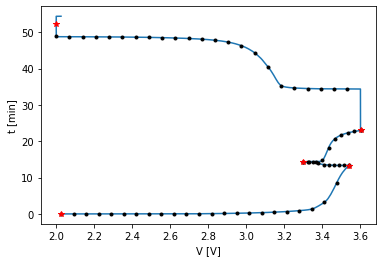

In [15]:
## Here is an example of feature extraction for the first battery in the list and c=1 (first cycle only)

batt = 0
N_points = [24, 10, 10, 24]
F_list = []

Feature_selected = 

for batt in range(0, 1):
    
    print(batt, 'batt')
    t_max_batt = return_tmax(batt)
    Ftot_ncycles =[]
    
    for c in range(1, 2):
        
        t_max = t_max_batt[c-1]
        Q = bat_dict[batt_names[batt]]['summary']['QD'][c]
        
        print(c, 'cycle #')
        times = bat_dict[batt_names[batt]]['cycles']['{}'.format(c)]['t']
        voltages = bat_dict[batt_names[batt]]['cycles']['{}'.format(c)]['V']
        voltages, times = eval_anomaly_end_discharge(voltages, times)   #here we uniform the beginnnig of each curve with the start of charging
        split_points = split_intervals(voltages, times)   # here we identify the splitting points 

        Fx, Fy = feature_extraction_1cycle(voltages, times, split_points, N_points)  # here the t@equispaced-V is interpolated
        F = np.c_[Fx, Fy] ## we save both 
        Ftot_1cycle = [F, Q]  ## this contains the voltage features and capacity Q for the battery batt and cycle c
        
        Ftot_ncycles.append(Ftot_1cycle)  ## here we append features from different cycles of the same battery 
   
        #here we visualize the collected voltage points vs real curve to detect eventual anomalies
    
        plt.figure()
        plt.plot(voltages, times)
        plt.plot(Fx, Fy, 'k.')
        for l in range(0, len(split_points)):
            plt.plot(voltages[split_points[l]], times[split_points[l]], 'r*')
        for s in []

        #plt.xlabel('normalized V [-]')
        plt.ylabel('t [min]')
        plt.xlabel('V [V]')
        plt.show()

        
# we can repeat the same for all the database (len(bat_dict.keys())
#we store each feature vector in a file called F_tot_batt_(battery_serial_number).pkl

    with open("F_tot_batt{}.pkl".format(batt), "wb") as fp:   #Pickling
        pickle.dump(Ftot_ncycles, fp)

    F_list.append(Ftot_ncycles)
    
print(F_list)
with open("F_tot_list.pkl", "wb") as fp:   #Pickling
    pickle.dump(Ftot_ncycles, fp)